## 1. Data Cleaning

In [1]:
import sys
print(sys.executable)

c:\Users\anton\AppData\Local\Programs\Python\Python313\python.exe


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE



In [3]:
DOUBLE11_DAY = 184

DIR_1 = 'data_format1/'
DIR_2 = 'data_format2/'

PATH_TRAIN = DIR_1 + 'train_format1.csv'
PATH_TEST = DIR_1 + 'test_format1.csv'
PATH_USER_INFO = DIR_1 + 'user_info_format1.csv'
PATH_USER_LOG = DIR_1 + 'user_log_format1.csv'

In [4]:
df_train = pd.read_csv(PATH_TRAIN)    
df_test = pd.read_csv(PATH_TEST) # this data has nan for the probabilities, the task is to predict the nan values. 
df_user_info = pd.read_csv(PATH_USER_INFO)
df_user_log = pd.read_csv(PATH_USER_LOG)

In [5]:
df_test['type'] = 'test'
df_train['type'] = 'train'

df_test = df_test.drop(columns=['prob'])

df = pd.concat([df_train, df_test]) # so that we add all the features to both dataframes, and then when we train we can divide between test and train again. 

In [6]:
print(len(df_test))

261477


In [7]:
print(len(df_train))

260864


In [8]:
print(df_train.head()) 

   user_id  merchant_id  label   type
0    34176         3906      0  train
1    34176          121      0  train
2    34176         4356      1  train
3    34176         2217      0  train
4   230784         4818      0  train


In [9]:
print(df_test.head()) 

   user_id  merchant_id  type
0   163968         4605  test
1   360576         1581  test
2    98688         1964  test
3    98688         3645  test
4   295296         3361  test


In [10]:
print(df.head())

   user_id  merchant_id  label   type
0    34176         3906    0.0  train
1    34176          121    0.0  train
2    34176         4356    1.0  train
3    34176         2217    0.0  train
4   230784         4818    0.0  train


In [11]:
print(df_user_info.head()) 

   user_id  age_range  gender
0   376517        6.0     1.0
1   234512        5.0     0.0
2   344532        5.0     0.0
3   186135        5.0     0.0
4    30230        5.0     0.0


In [12]:
df_user_log.rename(columns={'seller_id' : 'merchant_id'}, inplace=True)
print(df_user_log.head())

   user_id  item_id  cat_id  merchant_id  brand_id  time_stamp  action_type
0   328862   323294     833         2882    2661.0         829            0
1   328862   844400    1271         2882    2661.0         829            0
2   328862   575153    1271         2882    2661.0         829            0
3   328862   996875    1271         2882    2661.0         829            0
4   328862  1086186    1271         1253    1049.0         829            0


In [13]:
memory_original = df_user_log.memory_usage().sum() / 2**30

In [14]:
df_user_log['brand_id'] = df_user_log['brand_id'].fillna(0) #has nan values and decimals, no values equal to 0 (can use 0 as nan)
df_user_log['time_stamp']  = (pd.to_datetime(df_user_log['time_stamp'], format='%m%d') - pd.to_datetime(df_user_log['time_stamp'].min(), format= '%m%d')).dt.days # adds uneceary year (1900) but we want the benefits of the datetime operations.
#after we get a number of days from the earliest date in the dataset. It is just an int that is easy to work with. 

C:\Users\anton\AppData\Local\Temp\ipykernel_5620\1760434387.py:2: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  df_user_log['time_stamp']  = (pd.to_datetime(df_user_log['time_stamp'], format='%m%d') - pd.to_datetime(df_user_log['time_stamp'].min(), format= '%m%d')).dt.days # adds uneceary year (1900) but we want the benefits of the datetime operations.


In [15]:
df_user_log['user_id'] = df_user_log['user_id'].astype('int32') # reduce memory usage and speed up calculations
df_user_log['item_id'] = df_user_log['item_id'].astype('int32')
df_user_log['cat_id'] = df_user_log['cat_id'].astype('int16')
df_user_log['merchant_id'] = df_user_log['merchant_id'].astype('int16')
df_user_log['brand_id'] = df_user_log['brand_id'].astype('int16')
df_user_log['time_stamp'] = df_user_log['time_stamp'].astype('int16')
df_user_log['action_type'] = df_user_log['action_type'].astype('int8')

In [16]:
memory_optimized = round(df_user_log.memory_usage().sum() / 2**30,2)
memory_saved = round((memory_original - memory_optimized), 2)
print(f'{memory_optimized} GB ({memory_saved} GB saved)')

0.87 GB (1.99 GB saved)


In [17]:
df_user_info['gender'] = df_user_info['gender'].fillna(2) #0 for female, 1 for male, 2 and NULL for unknown.
df_user_info['gender'] = df_user_info['gender'].astype('int8')
df_user_info['age_range'] = df_user_info['age_range'].fillna(0) # 1 for <18; 2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50; 0 and NULL for unknown.
df_user_info['age_range'] = df_user_info['age_range'].astype('int8')
df_user_info['user_id'] = df_user_info['user_id'].astype('int32')

## 2. Feature Engineering

In [18]:
# features for each merchant and user
df_user_log['time_month'] = df_user_log['time_stamp'] // 30         # make a new column that represents the month
df_user_log['time_week'] = df_user_log['time_stamp'] // 7           # make a new column that represents the week

merchants = df_user_log.groupby('merchant_id')                      # Calculate total sales, number of transactions, average transaction value per merchant.
users = df_user_log.groupby('user_id')                              # Calculate statistics per user, such as total activity duration, number of actions, etc
merchants_users = df_user_log.groupby(['merchant_id', 'user_id'])   # Understand user behavior with specific merchants.


In [19]:
double11 = df_user_log[df_user_log['time_stamp'] == DOUBLE11_DAY].reset_index(drop=True) # get the data for the double 11 day
double11_merchants = double11.groupby('merchant_id') 
double11_users = double11.groupby('user_id')
double11_merchants_users = double11.groupby(['merchant_id', 'user_id'])

##### Unique merchant and user featues

In [20]:
to_merge = merchants.nunique().reset_index()
to_merge = to_merge.rename(columns={
    'item_id': 'items_merchant', 
    'cat_id': 'categories_merchant',
    'user_id': 'users_merchant',
    'brand_id': 'brands_merchant',
    'time_stamp': 'dates_merchant',
    'time_period': 'periods_merchant',
    'action_type': 'action_types_merchant'
    })
df = df.merge(to_merge, on='merchant_id', how='left')

to_merge = users.nunique().reset_index()            # 5 minutes. summary of unique counts per user
to_merge = to_merge.rename(columns={
    'item_id': 'items_user', 
    'cat_id': 'categories_user',
    'merchant_id': 'merchants_user',
    'brand_id': 'brands_user',
    'time_stamp': 'dates_user',
    'time_month': 'months_user',
    'time_week': 'weeks_user',
    'action_type': 'action_types_user'
})
df = df.merge(to_merge, on='user_id', how='left')

to_merge = merchants_users.nunique().reset_index()
to_merge = to_merge.rename(columns={
    'item_id': 'items_user_merchant', 
    'cat_id': 'categories_user_merchant',
    'brand_id': 'brands_user_merchant',
    'time_stamp': 'dates_user_merchant',
    'time_month': 'months_merchant',
    'time_week': 'weeks_merchant',
    'action_type': 'action_types_user_merchant'
    })
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

to_merge = users['action_type'].value_counts().unstack(fill_value=0)
to_merge = to_merge.rename(columns={
    0: 'clicks_user',
    1: 'add_to_carts_user',
    2: 'purchases_user',
    3: 'add_to_favorites_user'
})
df = df.merge(to_merge, on='user_id', how='left')   

to_merge = merchants['action_type'].value_counts().unstack(fill_value=0)
to_merge = to_merge.rename(columns={
    0: 'clicks_merchant',
    1: 'add_to_carts_merchant',
    2: 'purchases_merchant',
    3: 'add_to_favorites_merchant'
})
df = df.merge(to_merge, on='merchant_id', how='left')

to_merge = merchants_users['action_type'].value_counts().unstack(fill_value=0)
to_merge = to_merge.rename(columns={
    0: 'clicks_user_merchant',
    1: 'add_to_carts_user_merchant',
    2: 'purchases_user_merchant',
    3: 'add_to_favorites_user_merchant'
})
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

##### Ratio features

In [21]:
EPS = 1e-8

# ratio of actions from a merchant perspective
df['clicks_in_user_ratio'] = df['clicks_user_merchant'] / (df['clicks_merchant'] + EPS)
df['carts_in_user_ratio'] = df['add_to_carts_user_merchant'] / (df['add_to_carts_merchant'] + EPS)
df['purchases_in_user_ratio'] = df['purchases_user_merchant'] / (df['purchases_merchant'] + EPS)
df['favourites_in_user_ratio'] = df['add_to_favorites_user_merchant'] / (df['add_to_favorites_merchant'] + EPS)

# ratio of actions from a user perspective
df['clicks_in_merchant_ratio'] = df['clicks_user_merchant'] / (df['clicks_user'] + EPS)
df['carts_in_merchant_ratio'] = df['add_to_carts_user_merchant'] / (df['add_to_carts_user'] + EPS)
df['purchases_in_merchant_ratio'] = df['purchases_user_merchant'] / (df['purchases_user'] + EPS)
df['favourites_in_merchant_ratio'] = df['add_to_favorites_user_merchant'] / (df['add_to_favorites_user'] + EPS)

# ratio of action types for every merchant
df['temporary_total_actions_merchant'] = (df['clicks_merchant'] + df['add_to_carts_merchant'] + df['purchases_merchant'] + df['add_to_favorites_merchant'] + EPS)
df['clicks_ratio_merchant'] = df['clicks_merchant'] / (df['temporary_total_actions_merchant'])
df['carts_ratio_merchant'] = df['add_to_carts_merchant'] / (df['temporary_total_actions_merchant'])
df['purchases_ratio_merchant'] = df['purchases_merchant'] / (df['temporary_total_actions_merchant'])
df['favourites_ratio_merchant'] = df['add_to_favorites_merchant'] / (df['temporary_total_actions_merchant'])
df.drop('temporary_total_actions_merchant', axis=1, inplace=True)

# ratio of action types for every user
df['temporary_total_actions_user'] = (df['clicks_user'] + df['add_to_carts_user'] + df['purchases_user'] + df['add_to_favorites_user'] + EPS)
df['clicks_ratio_user'] = df['clicks_user'] / (df['temporary_total_actions_user'])
df['carts_ratio_user'] = df['add_to_carts_user'] / (df['temporary_total_actions_user'])
df['purchases_ratio_user'] = df['purchases_user'] / (df['temporary_total_actions_user'])
df['favourites_ratio_user'] = df['add_to_favorites_user'] / (df['temporary_total_actions_user'])
df.drop('temporary_total_actions_user', axis=1, inplace=True)

# ratio of action types for every user-merchant pair
df['temporary_total_actions_user_merchant'] = (df['clicks_user_merchant'] + df['add_to_carts_user_merchant'] + df['purchases_user_merchant'] + df['add_to_favorites_user_merchant'] + EPS)
df['clicks_ratio_user_merchant'] = df['clicks_user_merchant'] / (df['temporary_total_actions_user_merchant'])
df['carts_ratio_user_merchant'] = df['add_to_carts_user_merchant'] / (df['temporary_total_actions_user_merchant'])
df['purchases_ratio_user_merchant'] = df['purchases_user_merchant'] / (df['temporary_total_actions_user_merchant'])
df['favourites_ratio_user_merchant'] = df['add_to_favorites_user_merchant'] / (df['temporary_total_actions_user_merchant'])
df.drop('temporary_total_actions_user_merchant', axis=1, inplace=True)

In [22]:
# 1. total_repeat_purchases_user

# Count how many items a user purchased multiple times
user_purchases = df_user_log[df_user_log['action_type'] == 2]
user_item_purchase_counts = user_purchases.groupby(['user_id', 'item_id']).size().reset_index(name='purchase_count')
repeat_counts = user_item_purchase_counts[user_item_purchase_counts['purchase_count'] > 1].groupby('user_id')['item_id'].size().reset_index(name='total_repeat_purchases_user')
df = df.merge(repeat_counts, on='user_id', how='left').fillna({'total_repeat_purchases_user': 0})

# 2. is_top_merchant_user (1 if this merchant is the top one for that user by total interactions)
user_merchant_interactions = merchants_users.size().reset_index(name='interaction_count')
top_merchant_user_idx = user_merchant_interactions.loc[user_merchant_interactions.groupby('user_id')['interaction_count'].idxmax()]
top_merchant_user_idx['is_top_merchant_user'] = 1
df = df.merge(top_merchant_user_idx[['user_id', 'merchant_id', 'is_top_merchant_user']], on=['user_id', 'merchant_id'], how='left').fillna({'is_top_merchant_user':0})

# 3. category_overlap_user_merchant (40 sek)
user_categories = df_user_log.groupby('user_id')['cat_id'].apply(set).reset_index(name='user_cats_set')
merchant_categories = df_user_log.groupby('merchant_id')['cat_id'].apply(set).reset_index(name='merchant_cats_set')
df = df.merge(user_categories, on='user_id', how='left')
df = df.merge(merchant_categories, on='merchant_id', how='left')
df['category_overlap_user_merchant'] = df.apply(                                                    # Calculate overlap
    lambda row: len(row['user_cats_set'].intersection(row['merchant_cats_set'])) 
    if pd.notnull(row['user_cats_set']) and pd.notnull(row['merchant_cats_set']) else 0, axis=1
)
df = df.drop(['user_cats_set', 'merchant_cats_set'], axis=1) 

# Get unique brands per user
user_brands = df_user_log.groupby('user_id')['brand_id'].apply(set).reset_index(name='user_brands_set')
merchant_brands = df_user_log.groupby('merchant_id')['brand_id'].apply(set).reset_index(name='merchant_brands_set')
df = df.merge(user_brands, on='user_id', how='left')
df = df.merge(merchant_brands, on='merchant_id', how='left')
df['brand_overlap_user_merchant'] = df.apply(
    lambda row: len(row['user_brands_set'].intersection(row['merchant_brands_set'])) 
    if pd.notnull(row['user_brands_set']) and pd.notnull(row['merchant_brands_set']) else 0, axis=1
)
df = df.drop(['user_brands_set', 'merchant_brands_set'], axis=1)


# # Reference date (assuming the latest timestamp in the dataset)
# reference_date = df_user_log['time_stamp'].max()
# user_merchant_purchases = df_user_log[df_user_log['action_type'] == 2]
# last_purchase = user_merchant_purchases.groupby(['user_id', 'merchant_id'])['time_stamp'].max().reset_index(name='last_purchase_date_user_merchant')
# df = df.merge(last_purchase, on=['user_id', 'merchant_id'], how='left')
# df['R_recency_user_merchant'] = (reference_date - df_user_log['last_purchase_date_user_merchant'])
# df['R_recency_user_merchant'] = df['R_recency_user_merchant'].fillna(-1)  # or another appropriate value





In [23]:
def trendline(x, y):
    n = x.shape[1]
    sum_x = np.sum(x)
    sum_x_2 = np.sum(x**2)
    sum_y = np.sum(y, axis=1)
    u = (n * np.dot(y, x.T)) - (sum_x * sum_y).reshape(-1, 1)
    l = np.sum(sum_x_2) - (sum_x ** 2)
    return (u / l)

In [24]:
def create_time_features(df_log, df, entity_type='user', time_col='time_month'):
    
    suffix = 'month' if 'month' in time_col else 'week'
    
    # Group by entity_id and time_col
    entity_id_col = 'user_id' if entity_type == 'user' else 'merchant_id'
    grouped = df_log.groupby([entity_id_col, time_col])
    
    # Compute action counts per (entity, time)
    to_merge = (grouped['action_type'].value_counts()
                .unstack(fill_value=0)
                .rename(columns={
                    0: 'clicks_' + entity_type,
                    1: 'add_to_carts_' + entity_type,
                    2: 'purchases_' + entity_type,
                    3: 'add_to_favourites_' + entity_type
                })
                .reset_index())
    
    # Max statistics
    to_merge_aux = (to_merge.groupby(entity_id_col)
                    .max()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_' + entity_type: f'clicks_{entity_type}_{suffix}_max',
                        'add_to_carts_' + entity_type: f'carts_{entity_type}_{suffix}_max',
                        'purchases_' + entity_type: f'purchases_{entity_type}_{suffix}_max',
                        'add_to_favourites_' + entity_type: f'favourites_{entity_type}_{suffix}_max'
                    }))
    df = df.merge(to_merge_aux, on=entity_id_col, how='left')
    
    # Mean statistics
    to_merge_aux = (to_merge.groupby(entity_id_col)
                    .mean()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_' + entity_type: f'clicks_{entity_type}_{suffix}_mean',
                        'add_to_carts_' + entity_type: f'carts_{entity_type}_{suffix}_mean',
                        'purchases_' + entity_type: f'purchases_{entity_type}_{suffix}_mean',
                        'add_to_favourites_' + entity_type: f'favourites_{entity_type}_{suffix}_mean'
                    }))
    df = df.merge(to_merge_aux, on=entity_id_col, how='left')
    
    # Std statistics
    to_merge_aux = (to_merge.groupby(entity_id_col)
                    .std()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_' + entity_type: f'clicks_{entity_type}_{suffix}_std',
                        'add_to_carts_' + entity_type: f'carts_{entity_type}_{suffix}_std',
                        'purchases_' + entity_type: f'purchases_{entity_type}_{suffix}_std',
                        'add_to_favourites_' + entity_type: f'favourites_{entity_type}_{suffix}_std'
                    })
                    .fillna(0))
    df = df.merge(to_merge_aux, on=entity_id_col, how='left')
    
    # Median statistics
    to_merge_aux = (to_merge.groupby(entity_id_col)
                    .median()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_' + entity_type: f'clicks_{entity_type}_{suffix}_median',
                        'add_to_carts_' + entity_type: f'carts_{entity_type}_{suffix}_median',
                        'purchases_' + entity_type: f'purchases_{entity_type}_{suffix}_median',
                        'add_to_favourites_' + entity_type: f'favourites_{entity_type}_{suffix}_median'
                    }))
    df = df.merge(to_merge_aux, on=entity_id_col, how='left')
    
    # Pivot per time unit (month/week)
    to_merge_pivot = (to_merge
                      .groupby([entity_id_col, time_col])
                      .sum()
                      .unstack(fill_value=0)
                      .stack()
                      .reset_index())
    
    to_merge_pivot = (to_merge_pivot
                      .pivot_table(values=[f'clicks_{entity_type}', 
                                           f'add_to_carts_{entity_type}', 
                                           f'purchases_{entity_type}', 
                                           f'add_to_favourites_{entity_type}'],
                                   index=entity_id_col, 
                                   columns=time_col))
    
    # Rename columns to reflect month/week indexing
    to_merge_pivot.columns = [f"{col[0]}_{entity_type}_{suffix}_{col[1]}" for col in to_merge_pivot.columns.values]
    df = df.merge(to_merge_pivot, on=entity_id_col, how='left')
    
    return df

def create_trendline_features(df, entity_type='user', suffix='month', trendline_func=None):
 
    if trendline_func is None:
        # If no custom trendline func provided, assume `trendline` is defined globally
        trendline_func = trendline
    
    actions = ['purchases', 'clicks', 'carts', 'favourites']
    for action in actions:
        # Identify columns for this action and entity with the given suffix
        pattern = f"{action}_{entity_type}_{suffix}_"
        action_cols = [col for col in df.columns if col.startswith(pattern) and col.split('_')[-1].isdigit()]
        
        if not action_cols:
            # No columns found, skip
            continue
        
        # Extract time indices from the column names
        # Assuming single-digit time indices at the end of the column name
        # If multiple digits possible, use a more robust parsing method
        time_indices = [int(col.split('_')[-1]) for col in action_cols]
        
        # Ensure time_indices are sorted along with columns
        # Sort by time index to maintain consistent x ordering
        sorted_pairs = sorted(zip(time_indices, action_cols), key=lambda x: x[0])
        time_indices, action_cols = zip(*sorted_pairs)
        
        x = np.array(time_indices).reshape(1, -1)
        y = df[list(action_cols)].to_numpy()
        
        # Compute trendline
        df[f"{action}_{entity_type}_{suffix}_trendline"] = trendline_func(x, y)

    return df



# For user monthly features
df = create_time_features(df_user_log, df, entity_type='user', time_col='time_month')
df = create_trendline_features(df, entity_type='user', suffix='month', trendline_func=trendline)

# For user weekly features
df = create_time_features(df_user_log, df, entity_type='user', time_col='time_week')
df = create_trendline_features(df, entity_type='user', suffix='week', trendline_func=trendline)

# For merchant monthly features
df = create_time_features(df_user_log, df, entity_type='merchant', time_col='time_month')
df = create_trendline_features(df, entity_type='merchant', suffix='month', trendline_func=trendline)

# For merchant weekly features
df = create_time_features(df_user_log, df, entity_type='merchant', time_col='time_week')
df = create_trendline_features(df, entity_type='merchant', suffix='week', trendline_func=trendline)

C:\Users\anton\AppData\Local\Temp\ipykernel_5620\253234800.py:74: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack()
C:\Users\anton\AppData\Local\Temp\ipykernel_5620\253234800.py:74: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack()
C:\Users\anton\AppData\Local\Temp\ipykernel_5620\253234800.py:74: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack()
C

In [25]:
def create_time_features(df_user_log, df, time_col='time_month'): # made a function for code reuse between the month and week
    suffix = 'month' if 'month' in time_col else 'week'
    
    # Group by user_id and the specified time column
    users_time = df_user_log.groupby(['user_id', time_col])
    
    # Count action types per user_id and time_col
    to_merge = (users_time['action_type'].value_counts()
                .unstack(fill_value=0)
                .rename(columns={
                    0: 'clicks_user',
                    1: 'add_to_carts_user',
                    2: 'purchases_user',
                    3: 'add_to_favourites_user'
                })
                .reset_index())
    
    # Max statistics
    to_merge_aux = (to_merge.groupby('user_id')
                    .max()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_user': f'clicks_user_{suffix}_max',
                        'add_to_carts_user': f'carts_user_{suffix}_max',
                        'purchases_user': f'purchases_user_{suffix}_max',
                        'add_to_favourites_user': f'favourites_user_{suffix}_max'
                    }))
    df = df.merge(to_merge_aux, on='user_id', how='left')
    
    # Mean statistics
    to_merge_aux = (to_merge.groupby('user_id')
                    .mean()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_user': f'clicks_user_{suffix}_mean',
                        'add_to_carts_user': f'carts_user_{suffix}_mean',
                        'purchases_user': f'purchases_user_{suffix}_mean',
                        'add_to_favourites_user': f'favourites_user_{suffix}_mean'
                    }))
    df = df.merge(to_merge_aux, on='user_id', how='left')
    
    # Std statistics
    to_merge_aux = (to_merge.groupby('user_id')
                    .std()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_user': f'clicks_user_{suffix}_std',
                        'add_to_carts_user': f'carts_user_{suffix}_std',
                        'purchases_user': f'purchases_user_{suffix}_std',
                        'add_to_favourites_user': f'favourites_user_{suffix}_std'
                    })
                    .fillna(0))
    df = df.merge(to_merge_aux, on='user_id', how='left')
    
    # Median statistics
    to_merge_aux = (to_merge.groupby('user_id')
                    .median()
                    .drop(time_col, axis=1)
                    .rename(columns={
                        'clicks_user': f'clicks_user_{suffix}_median',
                        'add_to_carts_user': f'carts_user_{suffix}_median',
                        'purchases_user': f'purchases_user_{suffix}_median',
                        'add_to_favourites_user': f'favourites_user_{suffix}_median'
                    }))
    df = df.merge(to_merge_aux, on='user_id', how='left')
    
    # Pivot the data to create columns for each time unit (month/week)
    to_merge_pivot = (to_merge
                      .groupby(['user_id', time_col])
                      .sum()
                      .unstack(fill_value=0)
                      .stack(future_stack=True)
                      .reset_index())
    
    to_merge_pivot = (to_merge_pivot
                      .pivot_table(values=['clicks_user', 'add_to_carts_user', 'purchases_user', 'add_to_favourites_user'],
                                   index='user_id', 
                                   columns=time_col))
    
    # Rename columns to reflect month/week
    to_merge_pivot.columns = [f"{col[0]}_{suffix}_{col[1]}" for col in to_merge_pivot.columns.values]
    df = df.merge(to_merge_pivot, on='user_id', how='left')
    
    return df


df = create_time_features(df_user_log, df, time_col='time_month')
df = create_time_features(df_user_log, df, time_col='time_week')


In [26]:
users_merchants_time = df_user_log.groupby(['user_id', 'merchant_id', 'time_month']) # do the same for user and month, but cant use the same function

to_merge = users_merchants_time['action_type'].value_counts().unstack(fill_value=0).rename(columns={
    0: 'clicks_user_merchant',
    1: 'add_to_carts_user_merchant',
    2: 'purchases_user_merchant',
    3: 'add_to_favourites_user_merchant'
    }).reset_index()
to_merge = to_merge.groupby(['user_id', 'merchant_id', 'time_month']).sum().unstack().fillna(0).stack().reset_index()
to_merge = to_merge.pivot_table(values=['clicks_user_merchant', 'add_to_carts_user_merchant', 'purchases_user_merchant', 'add_to_favourites_user_merchant'], index=['user_id', 'merchant_id'], columns='time_month')
to_merge.columns = ['_period_'.join(str(x) for x in col) for col in to_merge.columns.values]
df = df.merge(to_merge, on=['user_id', 'merchant_id'], how='left')

# user-merchants trendline
purchase_col = [col for col in df if col.startswith('purchases_user_merchant_period') and col[-1].isdigit()]
x = np.array([int(col[-1]) for col in purchase_col]).reshape(1, -1)
y = df[purchase_col].to_numpy()
df['purchase_user_merchant_trendline'] = trendline(x, y)

clicks_col = [col for col in df if col.startswith('clicks_user_merchant_period') and col[-1].isdigit()]
y = df[clicks_col].to_numpy()
df['clicks_user_merchant_trendline'] = trendline(x, y)

carts_col = [col for col in df if col.startswith('add_to_carts_user_merchant_period') and col[-1].isdigit()]
y = df[carts_col].to_numpy()
df['add_to_carts_user_merchant_trendline'] = trendline(x, y)

favourites_col = [col for col in df if col.startswith('add_to_favourites_user_merchant_period') and col[-1].isdigit()]
y = df[favourites_col].to_numpy()
df['add_to_favourites_user_merchant_trendline'] = trendline(x, y)

C:\Users\anton\AppData\Local\Temp\ipykernel_5620\4259913673.py:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  to_merge = to_merge.groupby(['user_id', 'merchant_id', 'time_month']).sum().unstack().fillna(0).stack().reset_index()


##### Interval feature

In [28]:
to_merge = (users['time_stamp'].max() - users['time_stamp'].min()).rename('action_interval')
df = df.merge(to_merge, on='user_id', how='left')

df['is_top_merchant_user'] = df['is_top_merchant_user'].astype('int8')

In [29]:
print(df.head(10))

   user_id  merchant_id  label   type  users_merchant  items_merchant  \
0    34176         3906    0.0  train            5819             308   
1    34176          121    0.0  train           10931            1179   
2    34176         4356    1.0  train            2281              67   
3    34176         2217    0.0  train           16870             377   
4   230784         4818    0.0  train            7500             461   
5   362112         2618    0.0  train            1399              90   
6    34944         2051    0.0  train            6678             189   
7   231552         3828    1.0  train           76871            4691   
8   231552         2124    0.0  train           10274             837   
9   232320         1168    0.0  train            3468             521   

   categories_merchant  brands_merchant  dates_merchant  \
0                   20                2             185   
1                   26                2             185   
2                  

## 3. Training

In [184]:
df_train_features, df_test_features = df[df['type'] == 'train'], df[df['type'] == 'test']

df_train_features.loc[:, 'label'] = df_train_features['label'].astype(int)
df_train_features = df_train_features.drop(columns=['type','user_id', 'merchant_id'])
df_test_features = df_test_features.drop(columns=['type','user_id', 'merchant_id'])

X, y = df_train_features.drop(columns=['label']), df_train_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print("Means after scaling (should be close to 0):")
print(X_train.mean())

print("\nStandard deviations after scaling (should be 1):")
print(X_train.std())


Means after scaling (should be close to 0):
6.895138535785205e-18

Standard deviations after scaling (should be 1):
0.9924209433799058


In [185]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

scale_pos_weight = class_weights[1] / class_weights[0]
scale_pos_weight = sqrt(scale_pos_weight) + 7


print("Class Weights:", class_weight_dict)
print("Scale Pos Weight:", scale_pos_weight)

Class Weights: {0: np.float64(0.532684826889109), 1: np.float64(8.148809058961342)}
Scale Pos Weight: 10.91121696124399


In [ ]:
# define the model parameters
params = {
    'max_depth': 8,
    'n_estimators': 1000,
    'min_child_weight': 200,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eta': 0.02,
    'objective': 'binary:logistic', 
    'eval_metric': ['auc', 'logloss'], 
    'seed': 42,
    'early_stopping_rounds': 50,
    'scale_pos_weight': scale_pos_weight
}

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)


[0]	validation_0-auc:0.63686	validation_0-logloss:0.55850
[1]	validation_0-auc:0.65416	validation_0-logloss:0.55723
[2]	validation_0-auc:0.66256	validation_0-logloss:0.55592
[3]	validation_0-auc:0.66400	validation_0-logloss:0.55469
[4]	validation_0-auc:0.66866	validation_0-logloss:0.55348
[5]	validation_0-auc:0.66955	validation_0-logloss:0.55239
[6]	validation_0-auc:0.67067	validation_0-logloss:0.55136
[7]	validation_0-auc:0.67094	validation_0-logloss:0.55033
[8]	validation_0-auc:0.67288	validation_0-logloss:0.54923
[9]	validation_0-auc:0.67341	validation_0-logloss:0.54818
[10]	validation_0-auc:0.67410	validation_0-logloss:0.54705
[11]	validation_0-auc:0.67362	validation_0-logloss:0.54610
[12]	validation_0-auc:0.67372	validation_0-logloss:0.54508
[13]	validation_0-auc:0.67423	validation_0-logloss:0.54407
[14]	validation_0-auc:0.67526	validation_0-logloss:0.54315
[15]	validation_0-auc:0.67512	validation_0-logloss:0.54223
[16]	validation_0-auc:0.67554	validation_0-logloss:0.54133
[17]	va

In [188]:
filtered_features = importance_df[importance_df['Importance'] > 0.001]['Feature'].tolist()

X_filtered = X[filtered_features]

X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

scaler_filtered = StandardScaler()
X_train_filtered = scaler_filtered.fit_transform(X_train_filtered)
X_test_filtered = scaler_filtered.transform(X_test_filtered)

model = xgb.XGBClassifier(**params)
model.fit(X_train_filtered, y_train, eval_set=[(X_test_filtered, y_test)], verbose=True)

y_pred_proba = model.predict_proba(X_test_filtered)[:, 1]
y_pred = model.predict(X_test_filtered)



[0]	validation_0-auc:0.63808	validation_0-logloss:0.55853
[1]	validation_0-auc:0.65109	validation_0-logloss:0.55729
[2]	validation_0-auc:0.65599	validation_0-logloss:0.55596
[3]	validation_0-auc:0.66011	validation_0-logloss:0.55471
[4]	validation_0-auc:0.66658	validation_0-logloss:0.55348
[5]	validation_0-auc:0.66830	validation_0-logloss:0.55233
[6]	validation_0-auc:0.67080	validation_0-logloss:0.55126
[7]	validation_0-auc:0.67134	validation_0-logloss:0.55023
[8]	validation_0-auc:0.67267	validation_0-logloss:0.54916
[9]	validation_0-auc:0.67246	validation_0-logloss:0.54815
[10]	validation_0-auc:0.67274	validation_0-logloss:0.54709
[11]	validation_0-auc:0.67249	validation_0-logloss:0.54613
[12]	validation_0-auc:0.67320	validation_0-logloss:0.54506
[13]	validation_0-auc:0.67375	validation_0-logloss:0.54414
[14]	validation_0-auc:0.67379	validation_0-logloss:0.54324
[15]	validation_0-auc:0.67386	validation_0-logloss:0.54238
[16]	validation_0-auc:0.67358	validation_0-logloss:0.54149
[17]	va

## 4. Predicting 

In [190]:
print(y_test.sum())
print(y_pred.sum())

3147.0
7201


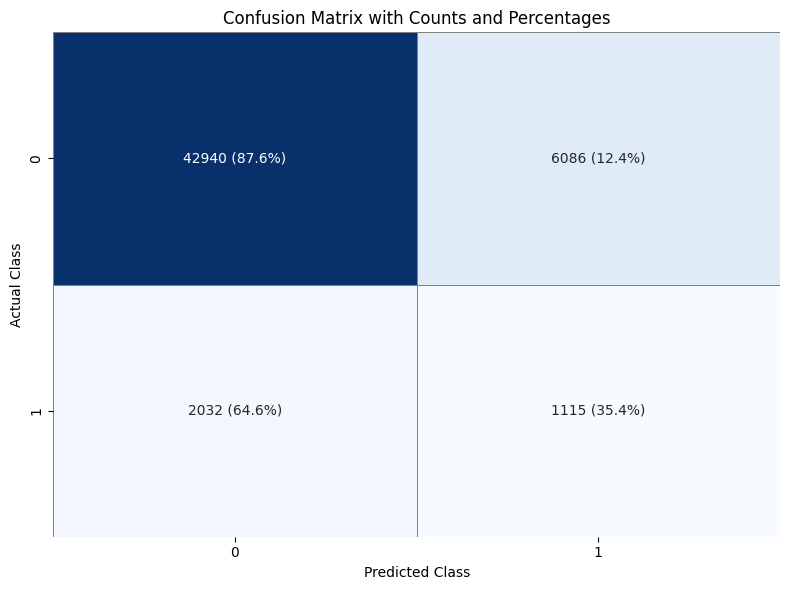

In [189]:
cm = confusion_matrix(y_test, y_pred)

# Calculate row-wise percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Multiply by 100 to get percentages
cm_percent = cm_percent * 100# Initialize an empty array for annotations
annot = np.empty_like(cm).astype(str)

# Populate the array with "count (percentage%)"
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = cm_percent[i, j]
        annot[i, j] = f"{count} ({percentage:.1f}%)"
# Set up the matplotlib figure
plt.figure(figsize=(8,6))

# Create the heatmap with annotations
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')

# Add titles and labels
plt.title('Confusion Matrix with Counts and Percentages')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()

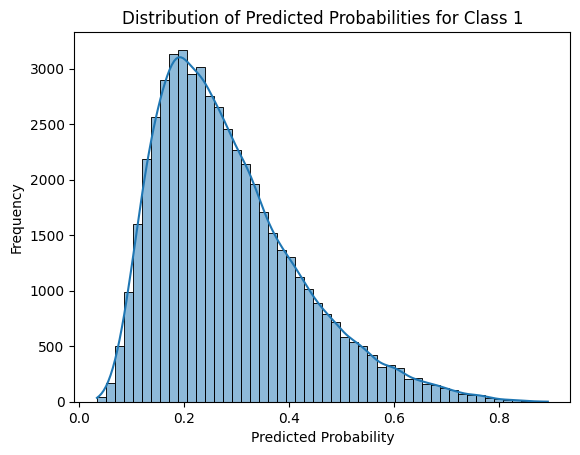

In [174]:
# Assuming y_pred_proba contains predicted probabilities for Class 1
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.title("Distribution of Predicted Probabilities for Class 1")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

In [63]:
print("Training set class distribution:")
print(y_train.value_counts())

print("\nTest set class distribution:")
print(y_test.value_counts())

Training set class distribution:
label
0.0    195886
1.0     12805
Name: count, dtype: int64

Test set class distribution:
label
0.0    49026
1.0     3147
Name: count, dtype: int64


In [191]:
features = df_test_features.drop(columns='label')

s_features = scaler_filtered.transform(features[filtered_features])

pred = model.predict(s_features)

print(pred.sum())


35685


In [192]:
submission = df_test.iloc[:,:2].join(pd.DataFrame(pred, index=df_test.index).rename(columns={0:'prob'}))
submission.to_csv('submission.csv', index=False)